# MDI341: TP Graphs
---
**Trinôme :** Daniel Gies - Mohammed Hssein - Maxime Lanvin


**Note**: Ce notebook a été conçu pour fonctionner avec
- Python 3 et NetworkX 2.4
- Python 2 et NetworkX 2.2

In [1]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import os.path
import urllib
import tarfile

In [2]:
print("Version de NetworkX: ", nx.__version__)

Version de NetworkX:  2.5


**Note** : la documentation de NetworkX se trouve [ici](http://networkx.readthedocs.io/)

## Analyse de graphes

### Erdős-Rényi

#### Question 1

On commence par créer et visualiser un graphe de type Erdős-Rényi avec n=200 noeuds et p=0.04. Vous aurez besoin des fonctions `nx.erdos_renyi_graph` et `nx.draw`.

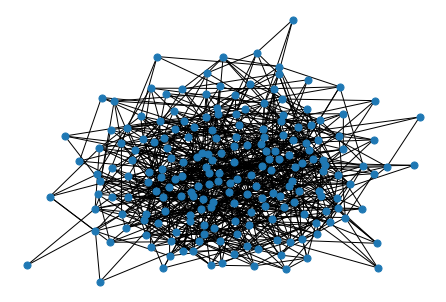

In [3]:
#paramètres du graph
n = 200
p = 0.04

#Création de graphe
G_erdos = nx.erdos_renyi_graph(n, p)
#Visulalisation du graphe
nx.draw(G_erdos, node_size=50)

#### Question 2

Calculons des statistiques sur le nombre d'arêtes et la distribution des degrés.

In [4]:
degree_sequence_erdos = list(dict(G_erdos.degree).values())
print("Le nombre de noeuds est :", len(degree_sequence_erdos))
print("Le nombre d'arrêtes est :", np.sum(degree_sequence_erdos)/2)
print("Le degré minimum est :", np.min(degree_sequence_erdos))
print("Le degré maximum est :", np.max(degree_sequence_erdos))
print("Le degré median est :", np.median(degree_sequence_erdos))
print("Le degré moyen est :", np.mean(degree_sequence_erdos))

Le nombre de noeuds est : 200
Le nombre d'arrêtes est : 814.0
Le degré minimum est : 2
Le degré maximum est : 16
Le degré median est : 8.0
Le degré moyen est : 8.14


------


**$\underline{Commentaires}$**


Soit $X_i$ le degré du noeud $i$. Alors d'après la construction du graphe, les $\{X_i\}_{i\leq 1 \leq n}$ sont indépendants. Le degré moyen est : 

$$
\bar X = \frac{1}{n} \sum_{i=1}^{n}X_i
$$

et sa valeur moyenne est de $\mathbb{E}(\bar X) = \mathbb{E}(X_1)$. Maintenant, on peut remarque que les variables $\{X_i\}_{i\leq 1 \leq n}$ admettent des moment d'ordre 2 (loi binomial), le controle (naif) par l'inégalité de Bienaymé-Tchebichev permet d'écrire : 

$$
\mathbb{P}(|\bar X - \mathbb{E}(\bar X)|\ge\epsilon) \leq \frac{\text{Var}(X_1)}{\epsilon^2 n} = \frac{np(1-p)}{n \epsilon^2} \sim \frac{1}{ \epsilon^2}
$$

La valeur de $\bar X$ est concentrée autour de sa moyenne.


On note que ce control, est satisfaisant, mais pas optimal. L'effet de $n$ n'apparait pas. On peut le faire apparaitre avec une autre approche. EN effet les variables $\{X_i\}_{i\leq 1 \leq n}$ sont toutes bornée (entre $0$ et $n$), on peut appliquer l'inégalité de Hoeffeding pour les v.a.r bornées (pas forcément indépendantes), pour trouver :

$$
\mathbb{P}(|\bar X - \mathbb{E}(\bar X)|\ge \epsilon) \leq 2 \exp \Big\{-2 \frac{\epsilon^2}{n^2} \Big\}
$$

Pour $n$ fixé, on voit que la décroissance est en $\exp(-\epsilon^2)$, qui est très rapide.



------

#### Question 3

On trace la distribution des degrés en échelle normale, puis en échelle log-log. La fonction `nx.degree_histogram` vous sera utile.

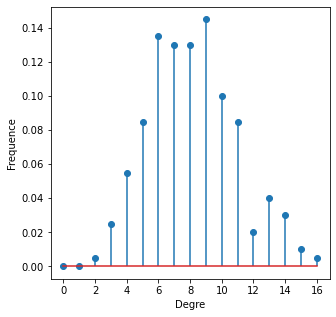

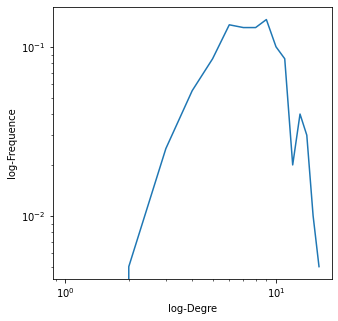

In [5]:
values, counts = np.unique(degree_sequence_erdos, return_counts=True)
degree_freq = counts/np.sum(counts)

y = nx.degree_histogram(G_erdos)/np.sum(counts)

plt.figure(figsize=(5, 5))
plt.stem(y, use_line_collection=True)
plt.ylabel("Frequence");
plt.xlabel("Degre");

plt.figure(figsize=(5, 5))
plt.loglog(y)
plt.ylabel("log-Frequence");
plt.xlabel("log-Degre");

In [6]:
print("N("+str(n*p)+","+str(n*p*(1-p))+ ")")

N(8.0,7.68)


------


**$\underline{Commentaires}$**

La distribution du degré d'un noeud suit une loi binomiale. Chaque noeud est tiré de manière indépedante, ainsi d'après le théorème centrale limite la distribution des degrés se comporte comme une loi normale $\mathcal{N}(8, 7.68)$ et c'est effectivement ce qu'on observe sur l'histogramme en échelle normale 

------

#### Question 4

On calcule maintenant le coefficient de clustering global (voir `nx.clustering`)

In [7]:
global_clustering_coef = np.mean(list(nx.clustering(G_erdos).values()))
print("Le coefficient de clustering global est :", global_clustering_coef)

Le coefficient de clustering global est : 0.046606407481407486


-------

**Commentaires**

On s'attend théoriquement à ce que $\mathbb{E}(C_c) = p$,

ici $p=0.04$ nous avons en moyenne $\mathbb{E}(C_c) = 0.038$ donc cela est tout à fait cohérent et respecte la valeur théorique.

-------

#### Question 5

On affiche la longueur moyenne des plus courts chemins et le diamètre du graphe

In [8]:
cpt = 0
nb_non_connexion = 0
for noeud, shortest_path_length in nx.all_pairs_shortest_path_length(G_erdos):
#     print(noeud, shortest_path_length, "\n")
#     print(np.sum((list(shortest_path_length.values()))))
    cpt+= np.sum((list(shortest_path_length.values())))
    nb_non_connexion += n - len(list(shortest_path_length))

nb_chemins = n*(n-1)/2
moy_spl = cpt / (2*nb_chemins)
print("La longueur moyenne des plus courts chemins est", moy_spl)
print("Le diamètre du graphe est", nx.diameter(G_erdos))

La longueur moyenne des plus courts chemins est 2.7444723618090454
Le diamètre du graphe est 5


### Barabási–Albert

#### Question 6

On crée et visualise maintenant un graphe de Barabási–Albert avec n=200 noeuds (on ajoute à chaque fois m=3 arêtes), puis on applique la même analyse que celle faite pour Erdős-Rényi

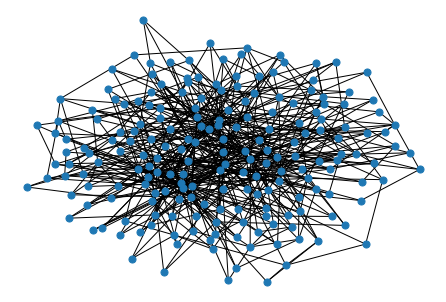

In [9]:
n = 200
m = 3
G_barabasi = nx.barabasi_albert_graph(n,m)
nx.draw(G_barabasi, node_size=50)

Calculons des statistiques sur le nombre d'arêtes et la distribution des degrés.

In [10]:
degree_sequence_erdos = list(dict(G_barabasi.degree).values())
print("Le nombre de noeuds est :", len(degree_sequence_erdos))
print("Le nombre d'arrêtes est :", np.sum(degree_sequence_erdos)/2)
print("Le degré minimum est :", np.min(degree_sequence_erdos))
print("Le degré maximum est :", np.max(degree_sequence_erdos))
print("Le degré median est :", np.median(degree_sequence_erdos))
print("Le degré mean est :", np.mean(degree_sequence_erdos))

Le nombre de noeuds est : 200
Le nombre d'arrêtes est : 591.0
Le degré minimum est : 3
Le degré maximum est : 33
Le degré median est : 4.0
Le degré mean est : 5.91


------


**Commentaires**

L'argument précédent pour le control ne marche pas ici pour la loi de probabilité $\zeta$ (ZETA). En effet : 

$$
\mathbb{E}(|X|^p) = \frac{1}{\zeta (\alpha)} \sum_{k\geq1} \frac{1}{k^{\alpha - p}}
$$ converge si et seulement si $p < \alpha - 1$. Utiliser une borne de Chernoff, ne marche pas car $\exp(|X|)$ n'est pas définit. Par contre, on peut essayer une inégalité de Chebechev classique : 

$$
\mathbb{P}(X \geq \epsilon) \leq \frac{\mathbb{E}(|X|^p)}{\epsilon^p} \implies\mathbb{P}(| X - \mathbb{E}(X)|\ge \epsilon) \leq \Big(\frac{2}{n \epsilon}\Big)^p \frac{\zeta(\alpha-p)}{\zeta(\alpha)}
$$
sous conditions $1 < \alpha < 2$ (V&rifié par notre graphe) et $p < \alpha -1 $ (*En effet le 2 apparait dans ce cas car la fonction $t \rightarrow |t|^p$ est concave dans ce cas et l'inégalité de Jensen permet de conclure*).

------

On trace la distribution des degrés en échelle normale, puis en échelle log-log. La fonction `nx.degree_histogram` vous sera utile.

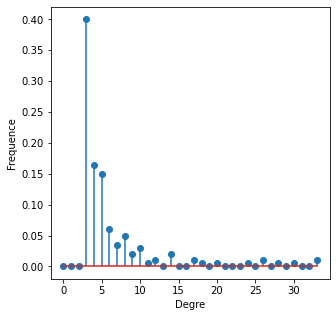

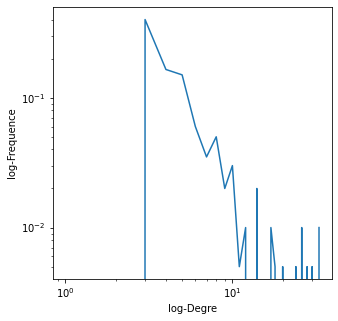

In [11]:
values, counts = np.unique(degree_sequence_erdos, return_counts=True)
degree_freq = counts/np.sum(counts)

y = nx.degree_histogram(G_barabasi)/np.sum(counts)

plt.figure(figsize=(5, 5))
plt.stem(y, use_line_collection=True)
plt.ylabel("Frequence");
plt.xlabel("Degre");

plt.figure(figsize=(5, 5))
plt.loglog(y)
plt.ylabel("log-Frequence");
plt.xlabel("log-Degre");

Le coef est  [[-1.71753289]]


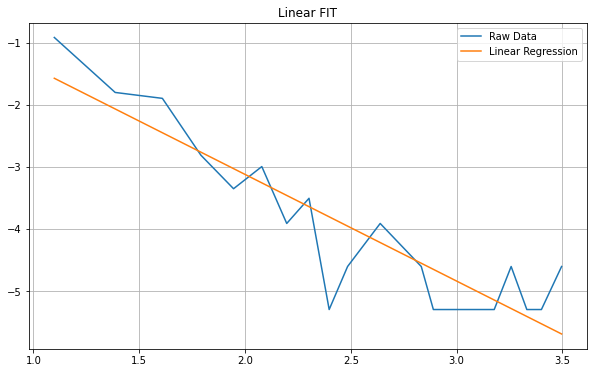

In [12]:
from sklearn.linear_model import LinearRegression
ind = np.nonzero(y>0)
X = np.array(np.log(ind)).reshape(-1)
Y = np.log(y[ind])
reg = LinearRegression().fit(X.reshape(-1,1), Y.reshape(-1,1))
print("Le coef est ", reg.coef_)
Y_pred = reg.predict(X.reshape(-1,1))
plt.figure(figsize=(10,6))
plt.plot(X, Y, label="Raw Data")
plt.plot(X, Y_pred, label="Linear Regression")
plt.title("Linear FIT")
plt.grid()
plt.legend()
plt.show()

------


**Commentaires**

La distribution du degré d'un noeud suit une loi $\zeta$ de paramètre $\alpha = 1.54$


------

On calcule maintenant le coefficient de clustering global (voir `nx.clustering`)

In [13]:
global_clustering_coef = np.mean(list(nx.clustering(G_barabasi).values()))
print("Le coefficient de clustering global est :", global_clustering_coef)

Le coefficient de clustering global est : 0.09174423709709176


On affiche la longueur moyenne des plus courts chemins et le diamètre du graphe

In [14]:
cpt = 0
nb_non_connexion = 0
for noeud, shortest_path_length in nx.all_pairs_shortest_path_length(G_barabasi):
    cpt+= np.sum((list(shortest_path_length.values())))
    nb_non_connexion += n - len(list(shortest_path_length))

nb_chemins = n*(n-1)/2
moy_spl = cpt / (2*nb_chemins)
print("La longueur moyenne des plus courts chemins est", moy_spl)
print("Le diamètre du graphe est", nx.diameter(G_barabasi))

La longueur moyenne des plus courts chemins est 2.8864824120603014
Le diamètre du graphe est 5


## Graphe Karate Club

On va maintenant travailler sur un graphe réel de petite taille (n=34, m=78) qui représente les liens d'amitié entre les adhérents d'un club de karaté (le graphe est intégré à la librairie `networkx`)

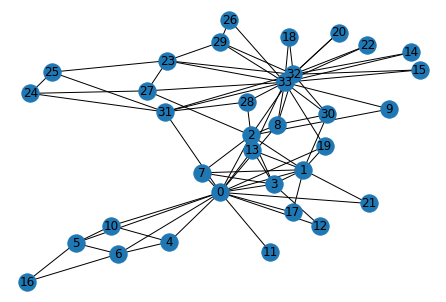

In [15]:
n=34
G_karate = nx.karate_club_graph()

# on définit une position des noeuds qui peut être ré-utilisée plusieurs fois
# en appelant la fonction nx.draw avec l'option pos=pos
pos = nx.spring_layout(G_karate)
nx.draw(G_karate, with_labels=True, pos=pos)

#### Question 7

On va appliquer un clustering hiérarchique pour faire de la détection de communauté. On calcule d'abord la matrice des distances entre noeuds, où la distance entre 2 noeuds correspond à la longueur du plus court chemin

In [16]:
# le code suivant calcule une matrice de taille n x n
# distances[i, j] contient la longueur du plus court chemin entre les noeuds i et j
pcc_longueurs=dict(nx.all_pairs_shortest_path_length(G_karate))
distances=np.zeros((n,n))

for i in range(n):
    for j in range(n):
        distances[i, j] = pcc_longueurs[i][j]

On peut maintenant utiliser l'implémentation de clustering hiérarchique ascendant de `scikit-learn` avec le *lien moyen* comme mesure de dissimilarité entre clusters. On affiche tout d'abord le clustering à 4 clusters, puis à 2 clusters.

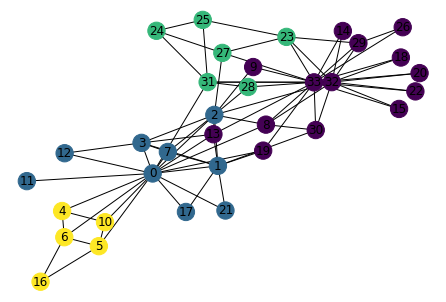

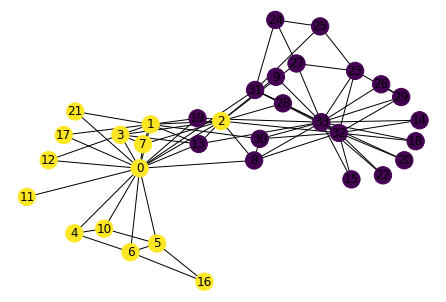

In [17]:
from sklearn.cluster import AgglomerativeClustering

# TODO QUESTION 7
adj_mat = nx.adjacency_matrix(G_karate).toarray()

## With 4 clusters
clustering = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage='average').fit(distances)
clustering.labels_
nx.draw(G_karate, node_color=clustering.labels_, with_labels=True)
plt.show()

## With 2 clusters
clustering = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage='average').fit(distances)
clustering.labels_
nx.draw(G_karate, node_color=clustering.labels_, with_labels=True)
plt.show()

#### Question 8

On va mettre en évidence visuellement les différences entre quelques mesures de centralité des noeuds

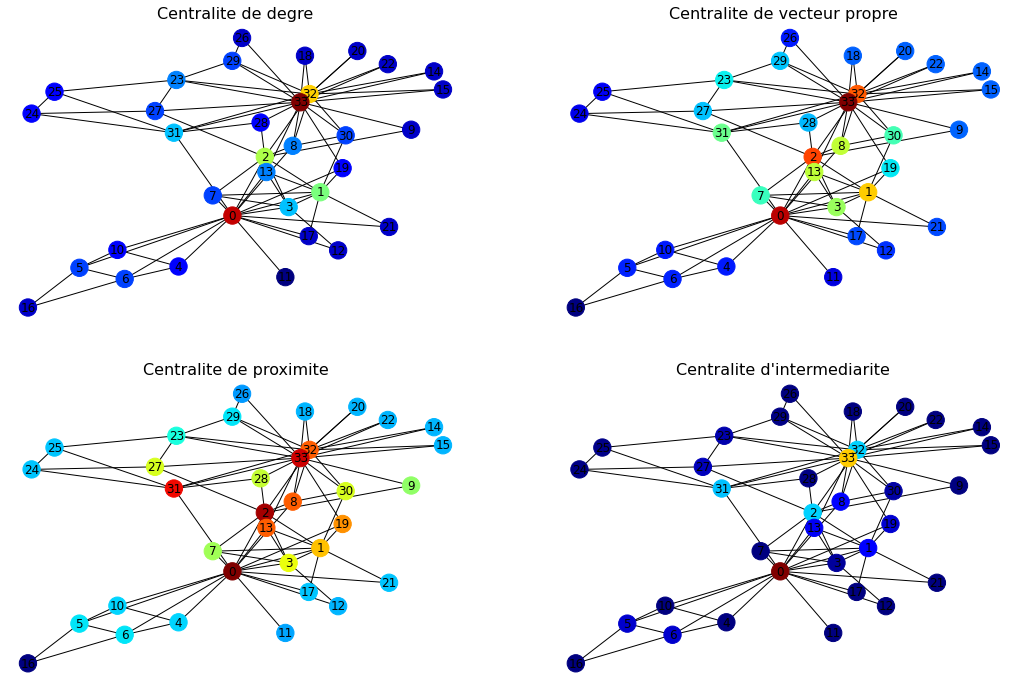

In [18]:
c_degree = list(nx.degree_centrality(G_karate).values())
c_eigenvector = list(nx.eigenvector_centrality(G_karate) .values())
c_closeness = list(nx.closeness_centrality(G_karate).values())
c_betweenness = list(nx.betweenness_centrality(G_karate).values())

plt.figure(figsize=(18, 12))
f, axarr = plt.subplots(2, 2, num=1)
plt.sca(axarr[0,0])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_degree, node_size=300, pos=pos, with_labels=True)
axarr[0,0].set_title('Centralite de degre', size=16);

plt.sca(axarr[0,1])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_eigenvector, node_size=300, pos=pos, with_labels=True)
axarr[0,1].set_title('Centralite de vecteur propre', size=16);

plt.sca(axarr[1,0])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_closeness, node_size=300, pos=pos, with_labels=True)
axarr[1,0].set_title('Centralite de proximite', size=16);

plt.sca(axarr[1,1])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_betweenness, node_size=300, pos=pos, with_labels=True)
axarr[1,1].set_title('Centralite d\'intermediarite', size=16);

### Graphe des produits Amazon

#### Question 9 (bonus +2 pts)

On va maintenant étudier un graphe de grande taille dont les noeuds sont des produits vendus par Amazon, et deux noeuds sont connectés si les deux produits sont fréquemment achetés ensemble (plus de détails [ici](https://snap.stanford.edu/data/com-Amazon.html))

In [19]:
if os.path.exists('amazon.txt.gz') is False:
    resp = urllib.urlretrieve('https://snap.stanford.edu/data/bigdata/' +
                       'communities/com-amazon.ungraph.txt.gz', 'amazon.txt.gz')

G_amazon = nx.read_edgelist('amazon.txt.gz')

## Prédiction dans les graphes

Un *ego-network* est un sous-graphe d'un réseau social centré sur un utilisateur. Ici on va travailler avec un ego-network Facebook (téléchargeable [ici](https://snap.stanford.edu/data/egonets-Facebook.html)) qui représente les amis d'un utilisateur donné (sans ce dernier) et les liens d'amitié entre eux. Le jeu de données contient 10 ego-networks, on va travailler avec l'un d'entre eux seulement qui se prête bien à la visualisation.

Nombre de noeuds: 150
Nombre d'arêtes: 1693
Nombre de composantes connexes: 2


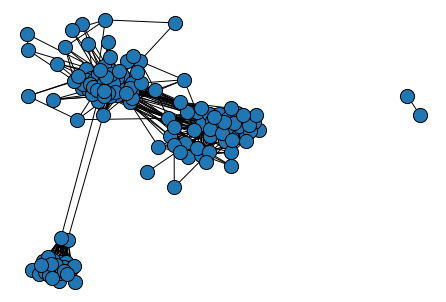

In [20]:
if os.path.exists('facebook.tar.gz') is False:
    resp = urllib.urlretrieve('https://snap.stanford.edu/data/facebook.tar.gz',
                              'facebook.tar.gz')
tarfile.open("facebook.tar.gz", 'r:gz').extractall('.')

G_fb = nx.read_edgelist("facebook/414.edges")
n = G_fb.number_of_nodes()
m = G_fb.number_of_edges()
# on renumérote les noeuds de 0 à n-1
mapping=dict(zip(G_fb.nodes(), range(n)))
nx.relabel_nodes(G_fb, mapping, copy=False)
pos = nx.spring_layout(G_fb, k=.2, seed=3)
nx.draw(G_fb, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
print("Nombre de noeuds: %d" % n)
print("Nombre d'arêtes: %d" % m)
print("Nombre de composantes connexes: %d" % nx.number_connected_components(G_fb))

#### Question 10

On va maintenant essayer de prédire des liens dans le réseau. Pour cela, on commence par extraire une proportion des arêtes du graphe, dont on cherchera à prédire l'existence parmi toutes les arêtes non-existantes possibles. Le graphe d'apprentissage est le graphe original auquel on retire les arêtes sélectionnées.

In [21]:
# G_fb_train est une copie du graphe original
# auquel on a retiré 20% des arêtes choisies aléatoirement

random.seed(5)
proportion_edges = 0.2
edge_subset = random.sample(G_fb.edges(),
                            int(proportion_edges * G_fb.number_of_edges()))
G_fb_train = G_fb.copy()
G_fb_train.remove_edges_from(edge_subset)

edge_subset_size = len(list(edge_subset))
print("Nombre d'arêtes retirées: %d" % edge_subset_size)
print("Nombre d'arêtes restantes: %d" % (m - edge_subset_size))
print("Nombre total d'arêtes non-existantes: %d" %
      len(list(nx.non_edges(G_fb_train))))

Nombre d'arêtes retirées: 338
Nombre d'arêtes restantes: 1355
Nombre total d'arêtes non-existantes: 9820


On veut scorer les arêtes non-existantes de façon à ce que les arêtes réelles retirées aient un plus grand score. On utilise plusieurs mesures de similarité entre paires de noeud et on calcule l'Aire sous la Courbe ROC (AUC). On trace également les courbes ROC pour chaque similarité.

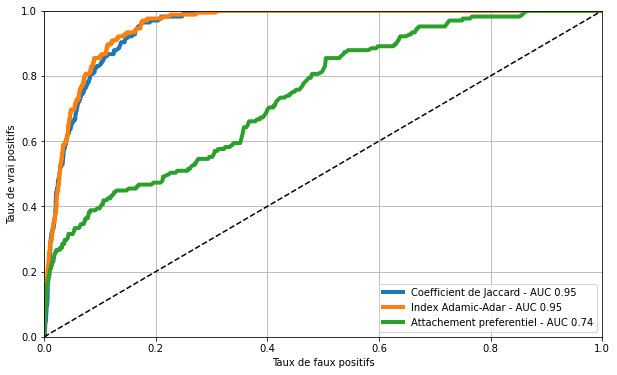

In [22]:
# exemple qui génère les scores et les labels (vrai arête ou fausse arête) avec jaccard
pred_jaccard = list(nx.jaccard_coefficient(G_fb_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])
fpr_jaccard, tpr_jaccard, _ = metrics.roc_curve(label_jaccard, score_jaccard)
auc_jaccard = metrics.auc(fpr_jaccard, tpr_jaccard)

#Adamic
pred_adamic = list(nx.adamic_adar_index(G_fb_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic])
fpr_adamic, tpr_adamic, _ = metrics.roc_curve(label_adamic, score_adamic)
auc_adamic = metrics.auc(fpr_adamic, tpr_adamic)

#Adamic
pred_pref = list(nx.preferential_attachment(G_fb_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref])
fpr_pref, tpr_pref, _ = metrics.roc_curve(label_pref, score_pref)
auc_pref = metrics.auc(fpr_pref, tpr_pref)



# afficher ROC curve et AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr_jaccard, tpr_jaccard, label='Coefficient de Jaccard - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Index Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Attachement preferentiel - AUC %.2f' % auc_pref, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#### Question 11

On va maintenant faire de la classification semi-supervisée des noeuds. Pour cela on va utiliser les attributs qui sont fournis avec l'ego-network. Ces attributs représentent des caractéristiques (anonymisées) des utilisateurs du réseau. Dans la suite nous allons utiliser l'attribut `43` qui vaut `+1` (rouge) si la personne a étudié dans une école donnée, et `-1` (bleu) sinon.

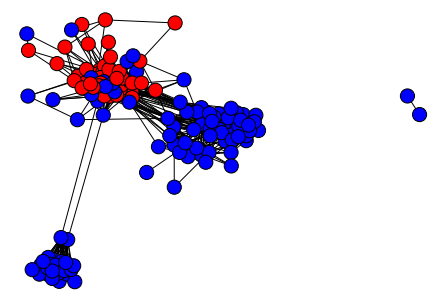

In [23]:
# on charge les labels des noeuds et on les affiche

with open('facebook/414.featnames') as f:
    for i, l in enumerate(f):
        pass

n_feat = i+1

features = np.zeros((n, n_feat))
f = open('facebook/414.feat', 'r')
for line in f:
    if line.split()[0] in mapping:
        node_id = mapping[line.split()[0]]
        features[node_id, :] = list(map(int, line.split()[1:]))
        
features = 2*features-1
feat_id = 43
labels = features[:, feat_id]

nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black

On voit que cet attribut est relativement lisse sur le graphe, il se prête donc bien à la classification par propagation de label (ce n'est pas le cas de tous les attributs!). On va donc sélectionner aléatoirement une petite proportion de noeuds pour lesquels nous aurons accès aux labels. Notre tâche sera d'utiliser ces noeuds étiquetés ainsi que la structure du graphe pour prédire le label des autres noeuds. On regarde d'abord les noeuds étiquetés.

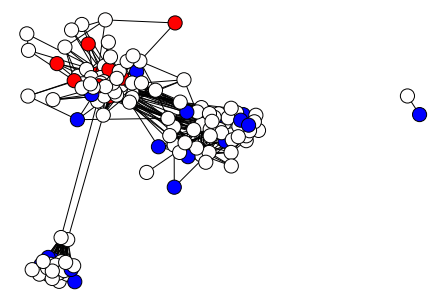

In [24]:
# on sélectionne 20% des noeuds pour lesquels on a accès à l'étiquette

random.seed(5)
proportion_nodes = 0.2
labeled_nodes = random.sample(G_fb.nodes(), int(proportion_nodes * G_fb.number_of_nodes()))

known_labels = np.zeros(n)
known_labels[labeled_nodes] = labels[labeled_nodes]

nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = known_labels, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black

On va maintenant appliquer la propagation de label et voir les résultats

NameError: name 'F_pred' is not defined

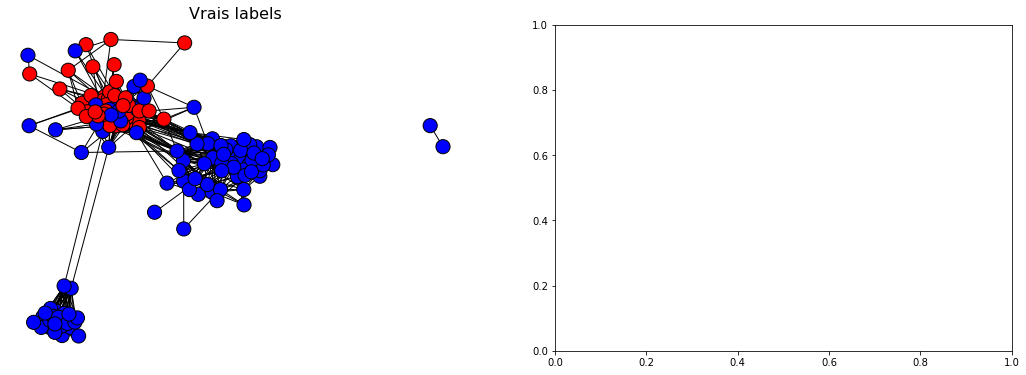

In [25]:
alpha = 0.7
L_sym = nx.normalized_laplacian_matrix(G_fb)

# on calcule la matrice de labels initiale
Y = np.zeros((n,2))
Y[known_labels==-1, 0] = 1
Y[known_labels==1, 1] = 1

# propagation de labels à faire ici

# labels prédits à mettre dans une variable F_pred pour affichage ci-dessous
# F_pred = 
# taux de succes a mettre dans une variable pred pour affichage ci-dessous
# pred = 

plt.figure(figsize=(18, 6))
f, axarr = plt.subplots(1, 2, num=1)
plt.sca(axarr[0])
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=200, pos=pos)
axarr[0].set_title('Vrais labels', size=16)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.sca(axarr[1])
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = F_pred, node_size=200, pos=pos)
axarr[1].set_title('Labels predits (taux de succes: %.2f)' % pred, size=16)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black